#### El primer objetivo es escribir la funcion de coste, es decir el hamiltoniano.  
Supongamos una funcion con una forma:  
$f(x) = ax^2 + bx +c$  
Queremos escribirla a partir de operadores de Pauli.
Ahora tenemos que discretizar la variable x y darle una cantidad y unos valores determinados.
Si queremos que tenga $N$ valores distintos necesitamos $n$ qubits donde: $n = \log_2 N$  
Vamos a suponer que queremos 4 valores para este caso, por tanto necesitamos 2 qbits. Tambien necesitamos asignar un rango para los valores, que podemos suponer que empiezan en el -2, por lo que 00 = -2; 01 = -1; 10 = 0; 11 = 1  

Si particularizamos la ecuacion que teniamos de ejemplo a algo como:  
$f(x)=x^2+3x−2$  
Ahora tendremos:  
| Estado  | x  | f(x) |
|---------|----|------|
| 00      | -2 | -4   |
| 01      | -1 | -4   |
| 10      |  0 | -2   |
| 11      |  1 |  2   |

Perfecto, ahora que tenemos los valores para cada qubit discretizado, tenemos que escribir el Hamiltoniano que queremos optimizar, para ello formulamos el hamiltoniano en funcion de operadores de pauli Z. Sabemos que el operador de pauli sigue:  
|0> -> Z = 1  
|1> -> Z = -1
| ∣q1q0⟩ | $Z_0$  | $Z_1$  | $Z_0Z_1$ |
|--------|----|----|------|
| ∣00⟩  | +1 | +1 | +1   |
| ∣01⟩  | -1 | +1 | -1   |
| ∣10⟩  | +1 | -1 | -1   |
| ∣11⟩  | -1 | -1 | +1   |


Ahora, escribimos un sistema de ecuaciones que seguira la forma:  
Eq1 -> $a_0 I + a_1 Z_0 + a_2 Z_1 +a_3 Z_0 Z_1 = f(-2)$ y las puertas de pauli corresponden a las del estado 1 |00>  
Por lo que para las siguientes ecuaciones sera  
Eq2 -> $a_0 I + a_1 Z_0 + a_2 Z_1 +a_3 Z_0 Z_1 = f(-1)$  
Eq3 -> $a_0 I + a_1 Z_0 + a_2 Z_1 +a_3 Z_0 Z_1 = f(0)$  
Eq4 -> $a_0 I + a_1 Z_0 + a_2 Z_1 +a_3 Z_0 Z_1 = f(1)$  

$$
\begin{cases}
a_0 + a_1 + a_2 + a_3 = -4 & \text{(para } |00\rangle \text{)} \\
a_0 - a_1 + a_2 - a_3 = -4 & \text{(para } |01\rangle \text{)} \\
a_0 + a_1 - a_2 - a_3 = -2 & \text{(para } |10\rangle \text{)} \\
a_0 - a_1 - a_2 + a_3 =  2 & \text{(para } |11\rangle \text{)}
\end{cases}
$$

Asi tendriamos finalmente nuestro sistema de ecuacion, que tras resolver tendriamos $a_0=−2$; $a_1=−1$; $a_2=−1$; $a_3=2$  
Y con esto ya tendriamos nuestra funcion de coste construida para este caso.  
$$
H_c = a_0 I + a_1 Z_0 + a_2 Z_1 +a_3 Z_0 Z_1 
$$

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import QasmSimulator
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

from sympy import symbols, Eq, solve

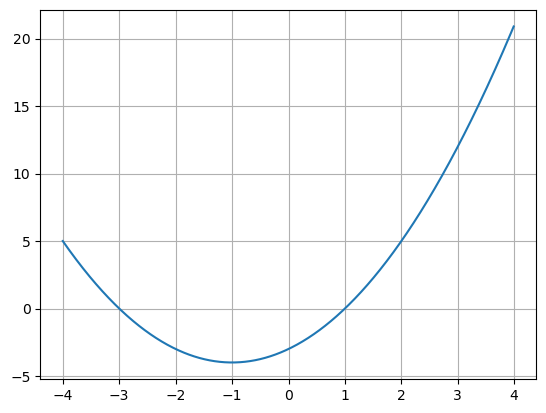

In [13]:
import matplotlib.pyplot as plt

x = np.arange(-4.0, 4, 0.01)
y = x**2 + 2*x -3

plt.plot(x, y)
#plt.ylim([0,10])
plt.grid()
plt.show()

In [82]:
n_qubits = 2 #numero de qubits para el circuito

x_vals = [0, 1, 2, 3]
qubit_states = ["00", "01", "10", "11"]


#definimos la funcion
def f(x):
    #return 3*x**4 -7*x**2 -0.5*x + 6
    #return x**2 + 3*x - 2
    return -2*(x**2) + 5*x - 4

def Hamiltonian(x_vals, qubit_states):

    # escribimos las condiciones
    equations = []
    Z_values = {
        "00": (+1, +1, +1),
        "01": (-1, +1, -1),
        "10": (+1, -1, -1),
        "11": (-1, -1, +1)
    }
    
    a0, a1, a2, a3 = symbols("a0 a1 a2 a3")
    
    #formamos el sistema de ecuaciones
    for i in range(n_qubits**2):
        z0, z1, z0z1 = Z_values[qubit_states[i]] # esta parte asigna los valores de las puertas de pauli
        print(type(a0 + a1*z0 + a2*z1 + a3*z0z1))
        eq = Eq(a0 + a1*z0 + a2*z1 + a3*z0z1, f(x_vals[i])) #el primer termino de Eq es la parte de la izquierda de la igualdad, y el segundo la parte de la derecha
        equations.append(eq)
    
    solution = solve(equations, (a0, a1, a2, a3))#estos son los valores que formaran nuestro hamiltoniano

    return solution
    
coeffs = Hamiltonian(x_vals, qubit_states)

#a0, a1, a2, a3 = coeffs[symbols("a0")], coeffs[symbols("a1")], coeffs[symbols("a2")], coeffs[symbols("a3")]

a0 = float(coeffs[symbols("a0")])
a1 = float(coeffs[symbols("a1")])
a2 = float(coeffs[symbols("a2")])
a3 = float(coeffs[symbols("a3")])

<class 'sympy.core.add.Add'>
<class 'sympy.core.add.Add'>
<class 'sympy.core.add.Add'>
<class 'sympy.core.add.Add'>


In [83]:
coeffs

{a0: -7/2, a1: 1/2, a2: 1, a3: -2}

#### QAOA
Ahora aplicaremos los pasos del QAOA

El QAOA se trata principalmente de dos operadores, uno que altera su de fase, sin alterar su probabilidad y otro a continuacion que alterla la probabilidad.  
El primero lo que hace es cambiar la fase de cada uno de los estados, dejando con mas fase el estado objetivo (solucion), cuan amplio es este cambio de fase viene dado por el parámetro $\gamma$.  
Y el segundo operador altera la probabilidad de los estados dejando los estados con mayor fase como los mas probables. Es el pàrametro $\beta$ el encargado regular cuanto altera las probabilidades.

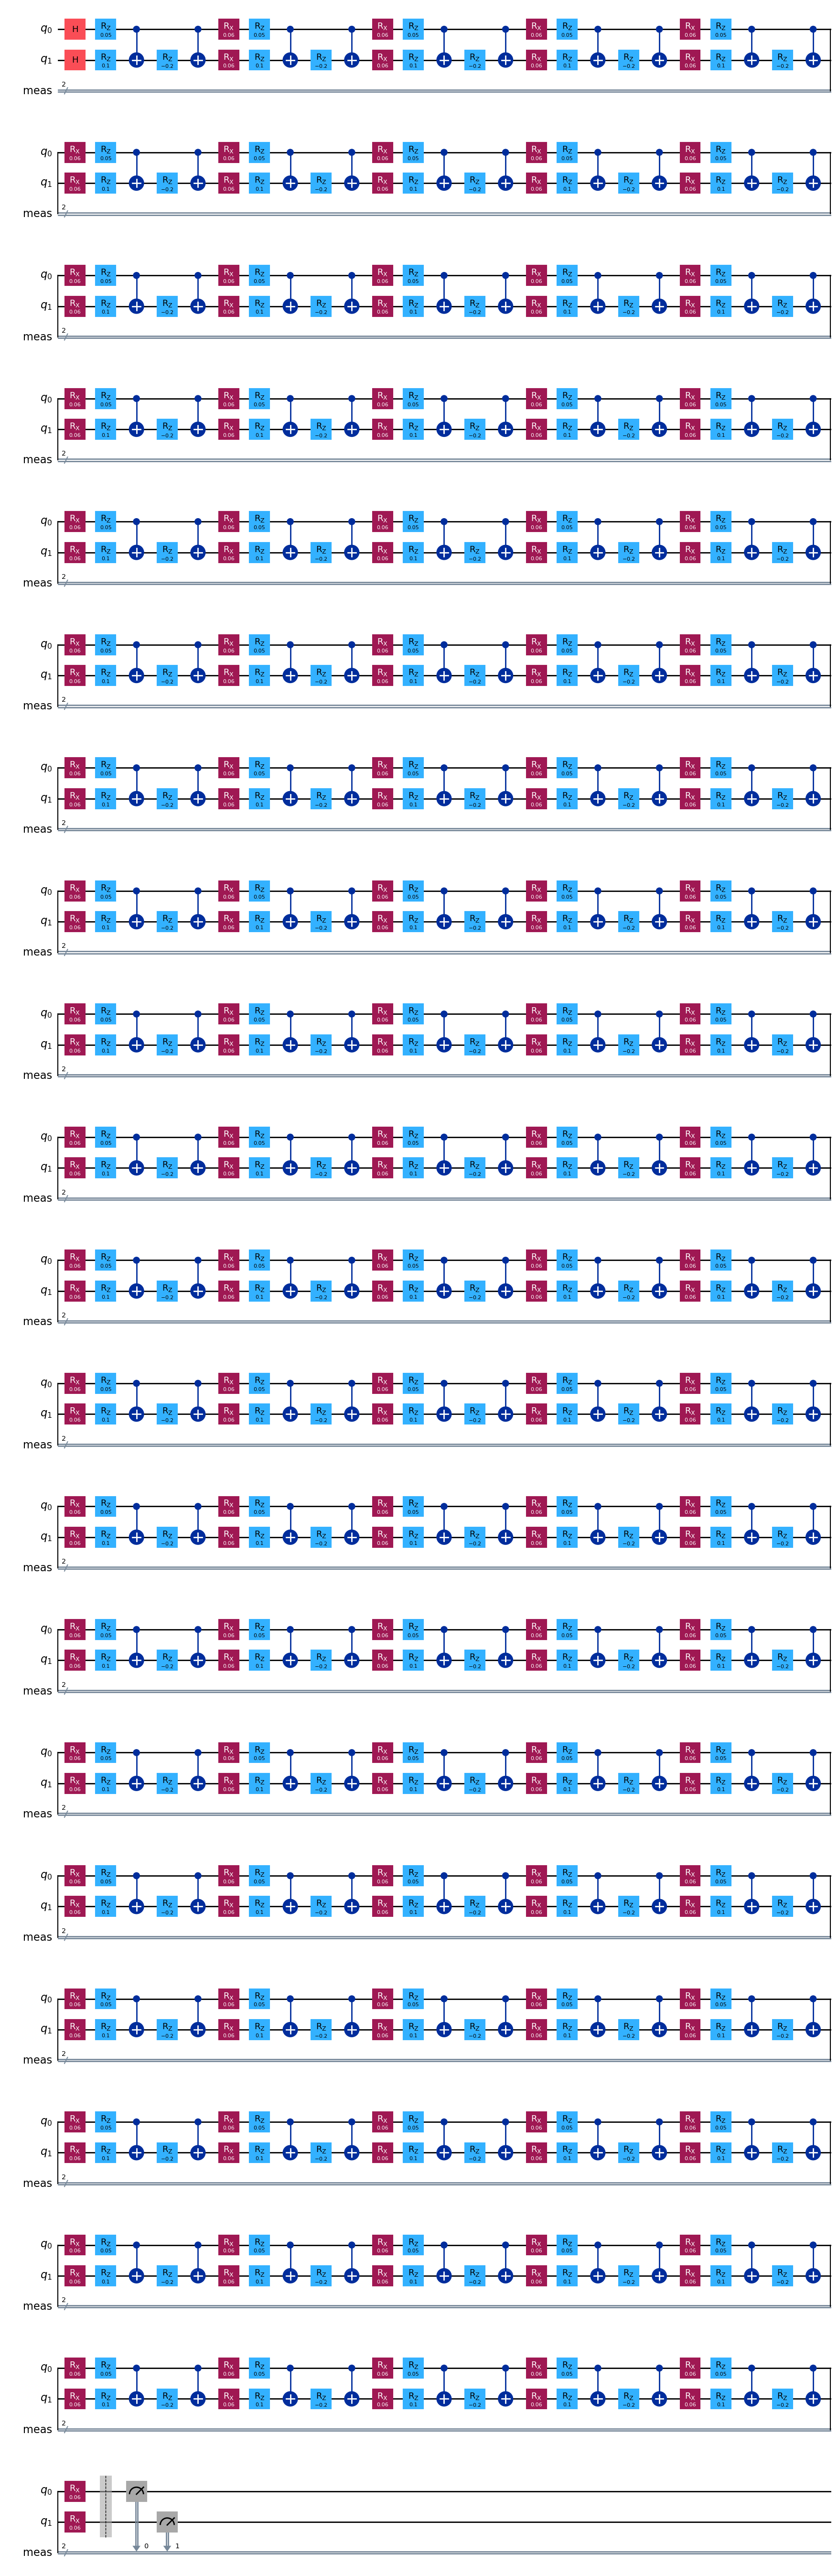

In [84]:
import numpy as np

def QAOA_circuit(n_qubits, gamma, beta, a0, a1, a2, a3, p=1):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    
    for _ in range(p):
        
        # Termino a1 * Z0
        qc.rz(2 * gamma * a1, 0)
        # Termino a2 * Z1
        qc.rz(2 * gamma * a2, 1)
        
        # Termino a3 * Z0Z1:
        qc.cx(0, 1)
        qc.rz(2 * gamma * a3, 1)
        qc.cx(0, 1)
        #Si los qubits están en ∣00⟩ o ∣11⟩, el estado no cambia.
        #Si están en ∣01⟩ o ∣10⟩, se introduce un signo negativo.

        
        for q in range(n_qubits):
            qc.rx(2 * beta, q)
    
    qc.measure_all()
    return qc

gamma = 0.05
beta = 0.03
p = 100

qc = QAOA_circuit(n_qubits, gamma, beta, a0, a1, a2, a3, p)

qc.draw('mpl')

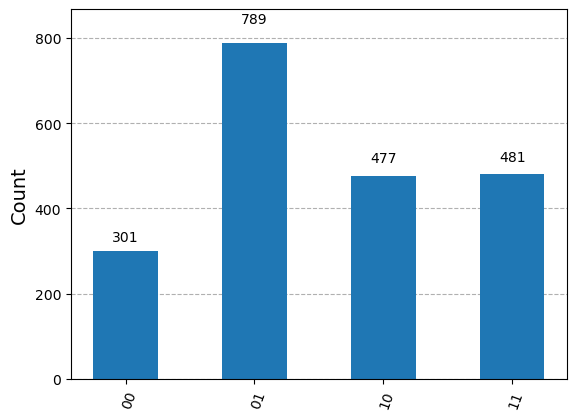

In [90]:

backend = QasmSimulator()
job = backend.run(qc, shots=2048)
counts = job.result().get_counts()

plot_histogram(counts)